In [1]:
import matplotlib.pyplot as plt

from platform import python_version
from scipy import stats

import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import matplotlib

import timeit
from tqdm import tqdm
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import preprocessing tools 
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression as mi
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

python version==3.8.3
pandas==1.0.5
numpy==1.18.5
sklearn==0.23.1
torch==1.7.0
matplotlib==3.2.2


In [3]:
print(os.listdir('DATA'))

train = pd.read_csv("DATA/train.csv").dropna(axis=1)
test = pd.read_csv("DATA/test.csv")

target = np.array(train['SalePrice'].values, np.float)

train.head()

['sample_submission.csv', 'test.csv', 'data_description.txt', 'house-prices-advanced-regression-techniques.zip', 'train.csv']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Preprocessing 

In [4]:
# Neighborhood is an important categorical, nominal feature 
# want to do the ordinal encoding manually 
def OrdinalEncoder(df, features, target='SalePrice'):
    # loop through all categorical features 
    for feature in features:
        neighborhoods = df[feature].values
        prices = []
        # for each feature, determine avg target value
        for neighborhood in np.unique(neighborhoods):
            inds = neighborhood == neighborhoods
            prices.append(np.mean(df.iloc[inds, :][target].values))
        ordinal_labels = np.argsort(prices)
        prices_dict = {neighborhood:i for i, neighborhood in enumerate(np.unique(neighborhoods)[ordinal_labels])}
        # encode categorical features ordinally based on target values 
        encoded_neighborhood = [prices_dict[n] for n in neighborhoods]
        df[feature] = encoded_neighborhood
    return df

# pull out categorical and continuous features 
continuousfeatures = train.describe().columns.values[1:-1] 
categoricalfeatures = [ftr for ftr in train.columns.values[1:-1] if ftr not in continuousfeatures]
features = list(continuousfeatures) + categoricalfeatures

# Assume categorical features are ordinal and encode 
train = OrdinalEncoder(train, categoricalfeatures)

# take decades since 2020 for features that describe the year 
yearfeatures = [f for f in features if 'Year' in f or 'Yr' in f]
train[yearfeatures] = (2020 - train[yearfeatures].values)/ 10

# take square root of features that describe area and divide by max 
areafeatures = [f for f in features if 'SF' in f or 'Area' in f]
train[areafeatures] = train[areafeatures].values**.5 / np.max(train[areafeatures].values**.5, 0)

# set up training data 
X = np.array(train[features].values, np.float)
y = np.array(train['SalePrice'].values, np.float)

# center data 
X = MinMaxScaler((-1, 1)).fit(X).transform(X)

# actually predict centered log_y 
y = np.log(y) - np.mean(np.log(y)) 

# set up a dataframe with features and target variables 
train[features] = X 
train['SalePrice'] = y
X_df = train[features]
y_df = train['SalePrice']

Create a dataset class for use with pytorch dataloader 

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X_df, y_df):
        # set up dataframe
        self.X_df = X_df
        self.y_df = y_df
        

    def __getitem__(self, index):
        
        # load X 
        features = self.X_df.values[index]
        x = torch.tensor(features, dtype=torch.float32)
        
        # load noisey y 
        target = self.y_df.values[index]
        y = torch.tensor(target, dtype=torch.float32)

        return x, y
        
    def __len__(self):
        # total size of your dataset.
        return len(self.X_df)

# Define NN model 

In [6]:
class Model(nn.Module):
    
    def __init__(self, in_dim, h_dim, out_dim=1):
        super(Model, self).__init__()
        self.input_size  = in_dim
        self.hidden_size = h_dim
        self.output_size = out_dim
        
        # define first fully connected layer 
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        
        # define optional second fully connected layer 
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        
        # add activation 
        self.activation = nn.ReLU()
        
        # define fully connected hidden layer 
        self.output = nn.Linear(self.hidden_size, self.output_size)    
        
    def forward(self, out):
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.output(out)
        return out

In [7]:
def NNtrain(model, trainloader, valloader, optimizer, criterion, num_epochs=300, patience=10, verbose=True, path_to_model='model.ckpt'): 
    # set up scheduler to reduce learning rate 
    scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=1e-5, mode='min', patience=0, verbose=True)
    best_val = np.inf
    
    for epoch in range(num_epochs):

        # set up model for training     
        model.train()
        for i, (x, y) in enumerate(trainloader):

            # send data to gpu or cpu RAM 
            # input has dimensions (sequence length, batch size, n inputs)
            x = x.to(device)

            # Forward pass
            output = model(x)
            
            # reshape targets to match output
            y = torch.reshape(y, [y.shape[0], 1])
            y = y.to(device)

            # Compute loss 
            loss = criterion(output, y) 
            # Backward pass
            loss.backward()       
            # Optimizer step
            optimizer.step()                        
            # Reset gradients   
            model.zero_grad()   
        

        # Evaluate validation data at end of each epoch
        valid_predictions = []
        valid_targets = []
        model.eval() 
        with torch.no_grad():
            for i, (x, y) in enumerate(valloader):
                x = x.to(device)

                # Forward pass
                output = model(x)

                # reshape targets to match output
                y = torch.reshape(y, [y.shape[0], 1])
                y = y.to(device)

                # Store predictions and true values 
                valid_predictions += list(output.detach().cpu().numpy())
                valid_targets += list(y.cpu().numpy())

        # Calculate performance statistics on validation data 
        val_rmse = np.linalg.norm(np.array(valid_predictions) - np.array(valid_targets))/len(np.array(valid_targets))

        # learning rate is reduced if val roc doesn't improve 
        scheduler.step(val_rmse)
        
        # Save model if validation performance improved 
        if val_rmse <= best_val:
            best_val = val_rmse  
            print("Saving model... Epoch [{}/{}], Val RMSE: {:.3f}\n".format(epoch+1, num_epochs, val_rmse))
            torch.save(model.state_dict(), path_to_model)  
        else:
            # if performance doesn't improve, lose some patience 
            patience -= 1
            if patience == 0:
                print('Early stopping. Best validation RMSE: {:.3f}'.format(best_val))
                break

    # Load best model from fold (in case last epoch was not best)
    model.load_state_dict(torch.load(path_to_model))
            
    return model

# Train model 

In [8]:
# set up training params
num_epochs = 150
n_splits_1 = 24
n_splits_2 = 6

# set up out of fold predictions
oof = np.zeros(len(X_df))

# split data into 10 train+validation and testing data sets
skf1 = KFold(n_splits=n_splits_1, shuffle=True, random_state=123)
skf1.get_n_splits(X_df, y_df)
for trainval_index, test_index in skf1.split(X_df):
    # split the whole dataset into training+validation data and testing sets
    X_trainval, X_test = X_df.iloc[trainval_index], X_df.iloc[test_index]
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_trainval, y_test = y_df.iloc[trainval_index], y_df.iloc[test_index]
    
    skf2 = KFold(n_splits=n_splits_2, shuffle=True, random_state=123)
    skf2.get_n_splits(X_trainval, y_trainval)
    y_pred_test = 0
    for train_index, val_index in skf2.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    
        # initialize the data set 
        train_dataset = Dataset(X_train, y_train)                                              
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32) 
        val_dataset  = Dataset(X_val, y_val)
        val_loader   = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32)

        # initialize model 
        model = Model(in_dim=len(features), h_dim=32, out_dim=1).to(device)

        # define lr and optimizer 
        optimizer = torch.optim.Adam(model.parameters(), lr=.01)
        criterion = torch.nn.MSELoss()

        ### train nn
        model = NNtrain(model, train_loader, val_loader, optimizer, criterion, num_epochs, verbose=True)

        # make predictions 
        y_pred_test += model(X_test).detach().cpu().numpy().flatten() / n_splits_2
    
    # store predictions
    oof[test_index] = y_pred_test

Saving model... Epoch [1/150], Val RMSE: 0.012

Saving model... Epoch [2/150], Val RMSE: 0.011

Saving model... Epoch [3/150], Val RMSE: 0.010

Saving model... Epoch [4/150], Val RMSE: 0.010

Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [6/150], Val RMSE: 0.010

Saving model... Epoch [7/150], Val RMSE: 0.010

Saving model... Epoch [8/150], Val RMSE: 0.010

Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.010
Saving model... Epoch [1/150], Val RMSE: 0.010

Epoch     2: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [3/150], Val RMSE: 0.009

Saving model... Epoch [4/150], Val RMSE: 0.009

Saving model... Epoch [5/150], Val RMSE: 0.009

Saving model... Epoch [6/150], Val RMSE: 0.009

Saving model... Epoch [7/150], Val RMSE: 0.009

Saving model... Epoch [8/150], Val RMSE: 0.009

Saving model... Epoch [9/150], Val R

Saving model... Epoch [33/150], Val RMSE: 0.008

Saving model... Epoch [34/150], Val RMSE: 0.008

Saving model... Epoch [35/150], Val RMSE: 0.008

Saving model... Epoch [36/150], Val RMSE: 0.008

Saving model... Epoch [37/150], Val RMSE: 0.008

Saving model... Epoch [38/150], Val RMSE: 0.008

Saving model... Epoch [39/150], Val RMSE: 0.008

Saving model... Epoch [41/150], Val RMSE: 0.008

Saving model... Epoch [42/150], Val RMSE: 0.008

Saving model... Epoch [43/150], Val RMSE: 0.008

Saving model... Epoch [44/150], Val RMSE: 0.008

Saving model... Epoch [45/150], Val RMSE: 0.008

Saving model... Epoch [46/150], Val RMSE: 0.008

Saving model... Epoch [47/150], Val RMSE: 0.008

Saving model... Epoch [48/150], Val RMSE: 0.008

Saving model... Epoch [49/150], Val RMSE: 0.008

Saving model... Epoch [50/150], Val RMSE: 0.008

Saving model... Epoch [52/150], Val RMSE: 0.008

Saving model... Epoch [53/150], Val RMSE: 0.008

Saving model... Epoch [54/150], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [44/150], Val RMSE: 0.009

Saving model... Epoch [45/150], Val RMSE: 0.009

Saving model... Epoch [46/150], Val RMSE: 0.009

Saving model... Epoch [47/150], Val RMSE: 0.009

Saving model... Epoch [48/150], Val RMSE: 0.009

Saving model... Epoch [49/150], Val RMSE: 0.009

Saving model... Epoch [50/150], Val RMSE: 0.009

Saving model... Epoch [51/150], Val RMSE: 0.009

Saving model... Epoch [52/150], Val RMSE: 0.009

Saving model... Epoch [53/150], Val RMSE: 0.009

Saving model... Epoch [54/150], Val RMSE: 0.009

Saving model... Epoch [55/150], Val RMSE: 0.009

Saving model... Epoch [56/150], Val RMSE: 0.009

Saving model... Epoch [57/150], Val RMSE: 0.009

Saving model... Epoch [58/150], Val RMSE: 0.009

Saving model... Epoch [59/150], Val RMSE: 0.009

Saving model... Epoch [60/150], Val RMSE: 0.009

Saving model... Epoch [61/150], Val RMSE: 0.009

Saving model... Epoch [62/150], Val RMSE: 0.009

Saving model... Epoch [63/150], Val RMSE: 0.009

Saving model... Epoc

Saving model... Epoch [20/150], Val RMSE: 0.008

Saving model... Epoch [21/150], Val RMSE: 0.008

Saving model... Epoch [22/150], Val RMSE: 0.008

Saving model... Epoch [23/150], Val RMSE: 0.008

Saving model... Epoch [24/150], Val RMSE: 0.008

Saving model... Epoch [25/150], Val RMSE: 0.008

Saving model... Epoch [26/150], Val RMSE: 0.008

Saving model... Epoch [27/150], Val RMSE: 0.008

Saving model... Epoch [28/150], Val RMSE: 0.008

Saving model... Epoch [29/150], Val RMSE: 0.008

Saving model... Epoch [30/150], Val RMSE: 0.008

Saving model... Epoch [31/150], Val RMSE: 0.008

Saving model... Epoch [32/150], Val RMSE: 0.008

Saving model... Epoch [33/150], Val RMSE: 0.008

Saving model... Epoch [34/150], Val RMSE: 0.008

Saving model... Epoch [35/150], Val RMSE: 0.008

Saving model... Epoch [36/150], Val RMSE: 0.008

Saving model... Epoch [37/150], Val RMSE: 0.008

Saving model... Epoch [38/150], Val RMSE: 0.008

Epoch    39: reducing learning rate of group 0 to 1.0000e-05.
Saving 

Saving model... Epoch [24/150], Val RMSE: 0.009

Saving model... Epoch [25/150], Val RMSE: 0.009

Saving model... Epoch [26/150], Val RMSE: 0.009

Saving model... Epoch [27/150], Val RMSE: 0.009

Saving model... Epoch [28/150], Val RMSE: 0.009

Saving model... Epoch [29/150], Val RMSE: 0.009

Saving model... Epoch [30/150], Val RMSE: 0.009

Saving model... Epoch [32/150], Val RMSE: 0.009

Saving model... Epoch [35/150], Val RMSE: 0.009

Saving model... Epoch [36/150], Val RMSE: 0.009

Early stopping. Best validation RMSE: 0.009
Saving model... Epoch [1/150], Val RMSE: 0.009

Saving model... Epoch [2/150], Val RMSE: 0.009

Saving model... Epoch [3/150], Val RMSE: 0.009

Saving model... Epoch [4/150], Val RMSE: 0.009

Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [6/150], Val RMSE: 0.008

Saving model... Epoch [7/150], Val RMSE: 0.008

Saving model... Epoch [8/150], Val RMSE: 0.008

Saving model... Epoch [9/150], Val RMSE: 0.008

Epoch    10: reducin

Saving model... Epoch [132/150], Val RMSE: 0.007

Saving model... Epoch [133/150], Val RMSE: 0.007

Saving model... Epoch [134/150], Val RMSE: 0.007

Saving model... Epoch [136/150], Val RMSE: 0.007

Saving model... Epoch [137/150], Val RMSE: 0.007

Saving model... Epoch [138/150], Val RMSE: 0.007

Saving model... Epoch [139/150], Val RMSE: 0.007

Saving model... Epoch [140/150], Val RMSE: 0.007

Saving model... Epoch [141/150], Val RMSE: 0.007

Saving model... Epoch [142/150], Val RMSE: 0.007

Saving model... Epoch [143/150], Val RMSE: 0.007

Saving model... Epoch [144/150], Val RMSE: 0.007

Saving model... Epoch [145/150], Val RMSE: 0.007

Saving model... Epoch [146/150], Val RMSE: 0.007

Saving model... Epoch [147/150], Val RMSE: 0.007

Saving model... Epoch [148/150], Val RMSE: 0.007

Saving model... Epoch [149/150], Val RMSE: 0.007

Saving model... Epoch [150/150], Val RMSE: 0.007

Saving model... Epoch [1/150], Val RMSE: 0.012

Saving model... Epoch [2/150], Val RMSE: 0.011

Epoc

Saving model... Epoch [150/150], Val RMSE: 0.009

Saving model... Epoch [1/150], Val RMSE: 0.011

Saving model... Epoch [2/150], Val RMSE: 0.009

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.
Epoch     5: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [5/150], Val RMSE: 0.009

Early stopping. Best validation RMSE: 0.009
Saving model... Epoch [1/150], Val RMSE: 0.010

Saving model... Epoch [2/150], Val RMSE: 0.010

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/150], Val RMSE: 0.010

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.010
Saving model... Epoch [1/150], Val RMSE: 0.008

Saving model... Epoch [2/150], Val RMSE: 0.008

Saving model... Epoch [3/150], Val RMSE: 0.007

Saving model... Epoch [4/150], Val RMSE: 0.007

Epoch     

Saving model... Epoch [80/150], Val RMSE: 0.007

Saving model... Epoch [81/150], Val RMSE: 0.007

Saving model... Epoch [82/150], Val RMSE: 0.007

Saving model... Epoch [83/150], Val RMSE: 0.007

Saving model... Epoch [84/150], Val RMSE: 0.007

Saving model... Epoch [85/150], Val RMSE: 0.007

Saving model... Epoch [86/150], Val RMSE: 0.007

Saving model... Epoch [87/150], Val RMSE: 0.007

Saving model... Epoch [88/150], Val RMSE: 0.007

Saving model... Epoch [89/150], Val RMSE: 0.007

Saving model... Epoch [90/150], Val RMSE: 0.007

Saving model... Epoch [91/150], Val RMSE: 0.007

Saving model... Epoch [92/150], Val RMSE: 0.007

Saving model... Epoch [93/150], Val RMSE: 0.007

Saving model... Epoch [95/150], Val RMSE: 0.007

Saving model... Epoch [96/150], Val RMSE: 0.007

Saving model... Epoch [97/150], Val RMSE: 0.007

Saving model... Epoch [98/150], Val RMSE: 0.007

Saving model... Epoch [99/150], Val RMSE: 0.007

Saving model... Epoch [100/150], Val RMSE: 0.007

Saving model... Epo

Saving model... Epoch [98/150], Val RMSE: 0.007

Saving model... Epoch [99/150], Val RMSE: 0.007

Saving model... Epoch [100/150], Val RMSE: 0.007

Saving model... Epoch [101/150], Val RMSE: 0.007

Saving model... Epoch [102/150], Val RMSE: 0.007

Saving model... Epoch [103/150], Val RMSE: 0.007

Saving model... Epoch [104/150], Val RMSE: 0.007

Saving model... Epoch [105/150], Val RMSE: 0.007

Saving model... Epoch [106/150], Val RMSE: 0.007

Saving model... Epoch [107/150], Val RMSE: 0.007

Saving model... Epoch [108/150], Val RMSE: 0.007

Saving model... Epoch [109/150], Val RMSE: 0.007

Saving model... Epoch [110/150], Val RMSE: 0.007

Saving model... Epoch [111/150], Val RMSE: 0.007

Saving model... Epoch [112/150], Val RMSE: 0.007

Saving model... Epoch [113/150], Val RMSE: 0.007

Saving model... Epoch [114/150], Val RMSE: 0.007

Saving model... Epoch [115/150], Val RMSE: 0.007

Saving model... Epoch [116/150], Val RMSE: 0.007

Saving model... Epoch [117/150], Val RMSE: 0.007

Sa

Saving model... Epoch [91/150], Val RMSE: 0.009

Saving model... Epoch [92/150], Val RMSE: 0.009

Saving model... Epoch [93/150], Val RMSE: 0.009

Saving model... Epoch [94/150], Val RMSE: 0.009

Saving model... Epoch [95/150], Val RMSE: 0.009

Saving model... Epoch [96/150], Val RMSE: 0.009

Saving model... Epoch [97/150], Val RMSE: 0.009

Saving model... Epoch [98/150], Val RMSE: 0.009

Saving model... Epoch [99/150], Val RMSE: 0.009

Saving model... Epoch [100/150], Val RMSE: 0.009

Saving model... Epoch [101/150], Val RMSE: 0.009

Saving model... Epoch [102/150], Val RMSE: 0.009

Saving model... Epoch [103/150], Val RMSE: 0.009

Saving model... Epoch [104/150], Val RMSE: 0.009

Saving model... Epoch [105/150], Val RMSE: 0.009

Saving model... Epoch [106/150], Val RMSE: 0.009

Saving model... Epoch [107/150], Val RMSE: 0.009

Saving model... Epoch [108/150], Val RMSE: 0.009

Saving model... Epoch [109/150], Val RMSE: 0.009

Saving model... Epoch [110/150], Val RMSE: 0.009

Saving mo

Saving model... Epoch [96/150], Val RMSE: 0.008

Saving model... Epoch [97/150], Val RMSE: 0.008

Saving model... Epoch [98/150], Val RMSE: 0.008

Saving model... Epoch [99/150], Val RMSE: 0.008

Saving model... Epoch [100/150], Val RMSE: 0.008

Saving model... Epoch [101/150], Val RMSE: 0.008

Saving model... Epoch [102/150], Val RMSE: 0.008

Saving model... Epoch [103/150], Val RMSE: 0.008

Saving model... Epoch [104/150], Val RMSE: 0.008

Saving model... Epoch [105/150], Val RMSE: 0.008

Saving model... Epoch [106/150], Val RMSE: 0.008

Saving model... Epoch [107/150], Val RMSE: 0.008

Saving model... Epoch [108/150], Val RMSE: 0.008

Saving model... Epoch [109/150], Val RMSE: 0.008

Saving model... Epoch [110/150], Val RMSE: 0.008

Saving model... Epoch [111/150], Val RMSE: 0.008

Saving model... Epoch [112/150], Val RMSE: 0.008

Saving model... Epoch [113/150], Val RMSE: 0.008

Saving model... Epoch [114/150], Val RMSE: 0.008

Saving model... Epoch [115/150], Val RMSE: 0.008

Savi

Saving model... Epoch [110/150], Val RMSE: 0.007

Saving model... Epoch [111/150], Val RMSE: 0.007

Saving model... Epoch [112/150], Val RMSE: 0.007

Saving model... Epoch [113/150], Val RMSE: 0.007

Saving model... Epoch [114/150], Val RMSE: 0.007

Saving model... Epoch [115/150], Val RMSE: 0.007

Saving model... Epoch [116/150], Val RMSE: 0.007

Saving model... Epoch [117/150], Val RMSE: 0.007

Saving model... Epoch [118/150], Val RMSE: 0.007

Saving model... Epoch [119/150], Val RMSE: 0.007

Saving model... Epoch [120/150], Val RMSE: 0.007

Saving model... Epoch [121/150], Val RMSE: 0.007

Saving model... Epoch [122/150], Val RMSE: 0.007

Saving model... Epoch [123/150], Val RMSE: 0.007

Saving model... Epoch [124/150], Val RMSE: 0.007

Saving model... Epoch [125/150], Val RMSE: 0.007

Saving model... Epoch [126/150], Val RMSE: 0.007

Saving model... Epoch [127/150], Val RMSE: 0.007

Saving model... Epoch [128/150], Val RMSE: 0.007

Saving model... Epoch [129/150], Val RMSE: 0.007



Saving model... Epoch [4/150], Val RMSE: 0.009

Saving model... Epoch [5/150], Val RMSE: 0.009

Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.009
Saving model... Epoch [1/150], Val RMSE: 0.011

Saving model... Epoch [2/150], Val RMSE: 0.008

Saving model... Epoch [3/150], Val RMSE: 0.008

Saving model... Epoch [4/150], Val RMSE: 0.007

Saving model... Epoch [5/150], Val RMSE: 0.007

Saving model... Epoch [6/150], Val RMSE: 0.007

Saving model... Epoch [7/150], Val RMSE: 0.007

Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [9/150], Val RMSE: 0.007

Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [11/150], Val RMSE: 0.007

Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.007
Saving model... Epoch [1/150], Val RMSE: 0.011

Saving model... Epoch [2/

Saving model... Epoch [5/150], Val RMSE: 0.009

Saving model... Epoch [6/150], Val RMSE: 0.009

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [8/150], Val RMSE: 0.009

Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [10/150], Val RMSE: 0.009

Saving model... Epoch [11/150], Val RMSE: 0.009

Saving model... Epoch [12/150], Val RMSE: 0.009

Saving model... Epoch [13/150], Val RMSE: 0.009

Saving model... Epoch [14/150], Val RMSE: 0.009

Saving model... Epoch [15/150], Val RMSE: 0.009

Saving model... Epoch [16/150], Val RMSE: 0.009

Saving model... Epoch [17/150], Val RMSE: 0.009

Saving model... Epoch [18/150], Val RMSE: 0.009

Saving model... Epoch [19/150], Val RMSE: 0.009

Saving model... Epoch [20/150], Val RMSE: 0.009

Saving model... Epoch [21/150], Val RMSE: 0.009

Saving model... Epoch [22/150], Val RMSE: 0.009

Saving model... Epoch [23/150], Val RMSE: 0.009

Saving model... Epoch [24/150], Val RMSE: 0.00

Saving model... Epoch [26/150], Val RMSE: 0.007

Saving model... Epoch [27/150], Val RMSE: 0.007

Saving model... Epoch [28/150], Val RMSE: 0.007

Saving model... Epoch [29/150], Val RMSE: 0.007

Saving model... Epoch [30/150], Val RMSE: 0.007

Saving model... Epoch [31/150], Val RMSE: 0.007

Saving model... Epoch [32/150], Val RMSE: 0.007

Saving model... Epoch [33/150], Val RMSE: 0.007

Saving model... Epoch [34/150], Val RMSE: 0.007

Saving model... Epoch [35/150], Val RMSE: 0.007

Saving model... Epoch [36/150], Val RMSE: 0.007

Saving model... Epoch [37/150], Val RMSE: 0.007

Saving model... Epoch [38/150], Val RMSE: 0.007

Saving model... Epoch [39/150], Val RMSE: 0.007

Saving model... Epoch [40/150], Val RMSE: 0.007

Saving model... Epoch [41/150], Val RMSE: 0.007

Saving model... Epoch [42/150], Val RMSE: 0.007

Saving model... Epoch [43/150], Val RMSE: 0.007

Saving model... Epoch [44/150], Val RMSE: 0.007

Saving model... Epoch [45/150], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [34/150], Val RMSE: 0.008

Saving model... Epoch [35/150], Val RMSE: 0.008

Saving model... Epoch [36/150], Val RMSE: 0.008

Epoch    37: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [37/150], Val RMSE: 0.008

Saving model... Epoch [38/150], Val RMSE: 0.008

Saving model... Epoch [39/150], Val RMSE: 0.008

Saving model... Epoch [40/150], Val RMSE: 0.008

Saving model... Epoch [41/150], Val RMSE: 0.008

Saving model... Epoch [42/150], Val RMSE: 0.008

Saving model... Epoch [43/150], Val RMSE: 0.008

Saving model... Epoch [44/150], Val RMSE: 0.008

Saving model... Epoch [45/150], Val RMSE: 0.008

Saving model... Epoch [46/150], Val RMSE: 0.008

Saving model... Epoch [47/150], Val RMSE: 0.008

Saving model... Epoch [48/150], Val RMSE: 0.008

Saving model... Epoch [49/150], Val RMSE: 0.008

Saving model... Epoch [50/150], Val RMSE: 0.008

Saving model... Epoch [51/150], Val RMSE: 0.008

Saving model... Epoch [52/150], Val RMSE: 0.008

Saving 

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/150], Val RMSE: 0.007

Saving model... Epoch [5/150], Val RMSE: 0.007

Saving model... Epoch [6/150], Val RMSE: 0.007

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [8/150], Val RMSE: 0.007

Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.007
Saving model... Epoch [1/150], Val RMSE: 0.013

Saving model... Epoch [2/150], Val RMSE: 0.011

Saving model... Epoch [3/150], Val RMSE: 0.011

Saving model... Epoch [4/150], Val RMSE: 0.011

Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [6/150], Val RMSE: 0.009

Saving model... Epoch [7/150], Val RMSE: 0.009

Saving model... Epoch [8/150], Val RMSE: 0.009

Saving model... Epoch [9/150], Val RMSE: 0.009

Saving model... Epoch [10/150], Val RMSE: 0.009

Saving model... Epoch [11/150], Val RMSE: 0.009

Saving model... Epoch [12/150], Va

Saving model... Epoch [26/150], Val RMSE: 0.007

Saving model... Epoch [27/150], Val RMSE: 0.007

Saving model... Epoch [28/150], Val RMSE: 0.007

Saving model... Epoch [29/150], Val RMSE: 0.007

Saving model... Epoch [30/150], Val RMSE: 0.007

Saving model... Epoch [31/150], Val RMSE: 0.007

Saving model... Epoch [32/150], Val RMSE: 0.007

Saving model... Epoch [33/150], Val RMSE: 0.007

Saving model... Epoch [34/150], Val RMSE: 0.007

Saving model... Epoch [35/150], Val RMSE: 0.007

Saving model... Epoch [36/150], Val RMSE: 0.007

Saving model... Epoch [37/150], Val RMSE: 0.007

Saving model... Epoch [38/150], Val RMSE: 0.007

Saving model... Epoch [39/150], Val RMSE: 0.007

Saving model... Epoch [40/150], Val RMSE: 0.007

Saving model... Epoch [41/150], Val RMSE: 0.007

Saving model... Epoch [42/150], Val RMSE: 0.007

Saving model... Epoch [43/150], Val RMSE: 0.007

Saving model... Epoch [44/150], Val RMSE: 0.007

Saving model... Epoch [45/150], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [41/150], Val RMSE: 0.009

Saving model... Epoch [42/150], Val RMSE: 0.009

Saving model... Epoch [43/150], Val RMSE: 0.009

Saving model... Epoch [44/150], Val RMSE: 0.009

Saving model... Epoch [45/150], Val RMSE: 0.009

Saving model... Epoch [46/150], Val RMSE: 0.009

Saving model... Epoch [47/150], Val RMSE: 0.009

Saving model... Epoch [48/150], Val RMSE: 0.009

Saving model... Epoch [49/150], Val RMSE: 0.009

Saving model... Epoch [50/150], Val RMSE: 0.009

Saving model... Epoch [51/150], Val RMSE: 0.009

Saving model... Epoch [52/150], Val RMSE: 0.009

Saving model... Epoch [53/150], Val RMSE: 0.009

Saving model... Epoch [54/150], Val RMSE: 0.009

Saving model... Epoch [55/150], Val RMSE: 0.009

Saving model... Epoch [56/150], Val RMSE: 0.009

Saving model... Epoch [57/150], Val RMSE: 0.009

Saving model... Epoch [58/150], Val RMSE: 0.009

Saving model... Epoch [59/150], Val RMSE: 0.009

Saving model... Epoch [60/150], Val RMSE: 0.009

Saving model... Epoc

Saving model... Epoch [57/150], Val RMSE: 0.008

Saving model... Epoch [58/150], Val RMSE: 0.008

Saving model... Epoch [59/150], Val RMSE: 0.008

Saving model... Epoch [60/150], Val RMSE: 0.008

Saving model... Epoch [61/150], Val RMSE: 0.008

Saving model... Epoch [62/150], Val RMSE: 0.008

Saving model... Epoch [63/150], Val RMSE: 0.008

Saving model... Epoch [64/150], Val RMSE: 0.008

Saving model... Epoch [65/150], Val RMSE: 0.008

Saving model... Epoch [66/150], Val RMSE: 0.008

Saving model... Epoch [67/150], Val RMSE: 0.008

Saving model... Epoch [68/150], Val RMSE: 0.008

Saving model... Epoch [69/150], Val RMSE: 0.008

Saving model... Epoch [70/150], Val RMSE: 0.008

Saving model... Epoch [71/150], Val RMSE: 0.008

Saving model... Epoch [72/150], Val RMSE: 0.008

Saving model... Epoch [73/150], Val RMSE: 0.008

Saving model... Epoch [74/150], Val RMSE: 0.008

Saving model... Epoch [75/150], Val RMSE: 0.008

Saving model... Epoch [76/150], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [79/150], Val RMSE: 0.007

Saving model... Epoch [80/150], Val RMSE: 0.007

Saving model... Epoch [81/150], Val RMSE: 0.007

Saving model... Epoch [82/150], Val RMSE: 0.007

Saving model... Epoch [83/150], Val RMSE: 0.007

Saving model... Epoch [84/150], Val RMSE: 0.007

Saving model... Epoch [85/150], Val RMSE: 0.007

Saving model... Epoch [86/150], Val RMSE: 0.007

Saving model... Epoch [87/150], Val RMSE: 0.007

Saving model... Epoch [88/150], Val RMSE: 0.007

Saving model... Epoch [89/150], Val RMSE: 0.007

Saving model... Epoch [90/150], Val RMSE: 0.007

Saving model... Epoch [91/150], Val RMSE: 0.007

Saving model... Epoch [92/150], Val RMSE: 0.007

Saving model... Epoch [93/150], Val RMSE: 0.007

Saving model... Epoch [94/150], Val RMSE: 0.007

Saving model... Epoch [95/150], Val RMSE: 0.007

Saving model... Epoch [96/150], Val RMSE: 0.007

Saving model... Epoch [97/150], Val RMSE: 0.007

Saving model... Epoch [98/150], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [70/150], Val RMSE: 0.007

Saving model... Epoch [71/150], Val RMSE: 0.007

Saving model... Epoch [72/150], Val RMSE: 0.007

Saving model... Epoch [73/150], Val RMSE: 0.007

Saving model... Epoch [74/150], Val RMSE: 0.007

Epoch    75: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [76/150], Val RMSE: 0.007

Saving model... Epoch [77/150], Val RMSE: 0.007

Saving model... Epoch [78/150], Val RMSE: 0.007

Saving model... Epoch [79/150], Val RMSE: 0.007

Saving model... Epoch [80/150], Val RMSE: 0.007

Saving model... Epoch [81/150], Val RMSE: 0.007

Saving model... Epoch [82/150], Val RMSE: 0.007

Saving model... Epoch [83/150], Val RMSE: 0.007

Saving model... Epoch [84/150], Val RMSE: 0.007

Saving model... Epoch [85/150], Val RMSE: 0.007

Saving model... Epoch [86/150], Val RMSE: 0.007

Saving model... Epoch [87/150], Val RMSE: 0.007

Saving model... Epoch [88/150], Val RMSE: 0.007

Saving model... Epoch [89/150], Val RMSE: 0.007

Saving 

Saving model... Epoch [74/150], Val RMSE: 0.007

Saving model... Epoch [75/150], Val RMSE: 0.007

Saving model... Epoch [76/150], Val RMSE: 0.007

Saving model... Epoch [77/150], Val RMSE: 0.007

Saving model... Epoch [78/150], Val RMSE: 0.007

Saving model... Epoch [79/150], Val RMSE: 0.007

Saving model... Epoch [80/150], Val RMSE: 0.007

Saving model... Epoch [81/150], Val RMSE: 0.007

Saving model... Epoch [82/150], Val RMSE: 0.007

Saving model... Epoch [83/150], Val RMSE: 0.007

Saving model... Epoch [84/150], Val RMSE: 0.007

Saving model... Epoch [85/150], Val RMSE: 0.007

Saving model... Epoch [86/150], Val RMSE: 0.007

Saving model... Epoch [87/150], Val RMSE: 0.007

Saving model... Epoch [88/150], Val RMSE: 0.007

Saving model... Epoch [89/150], Val RMSE: 0.007

Saving model... Epoch [90/150], Val RMSE: 0.007

Saving model... Epoch [91/150], Val RMSE: 0.007

Saving model... Epoch [92/150], Val RMSE: 0.007

Saving model... Epoch [93/150], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [34/150], Val RMSE: 0.008

Saving model... Epoch [35/150], Val RMSE: 0.008

Saving model... Epoch [36/150], Val RMSE: 0.008

Saving model... Epoch [37/150], Val RMSE: 0.008

Saving model... Epoch [38/150], Val RMSE: 0.008

Saving model... Epoch [39/150], Val RMSE: 0.008

Saving model... Epoch [40/150], Val RMSE: 0.008

Saving model... Epoch [41/150], Val RMSE: 0.008

Saving model... Epoch [42/150], Val RMSE: 0.008

Saving model... Epoch [43/150], Val RMSE: 0.008

Saving model... Epoch [44/150], Val RMSE: 0.008

Saving model... Epoch [45/150], Val RMSE: 0.008

Saving model... Epoch [46/150], Val RMSE: 0.008

Saving model... Epoch [47/150], Val RMSE: 0.008

Saving model... Epoch [48/150], Val RMSE: 0.008

Saving model... Epoch [49/150], Val RMSE: 0.008

Saving model... Epoch [50/150], Val RMSE: 0.008

Saving model... Epoch [51/150], Val RMSE: 0.008

Saving model... Epoch [52/150], Val RMSE: 0.008

Saving model... Epoch [53/150], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [42/150], Val RMSE: 0.008

Saving model... Epoch [43/150], Val RMSE: 0.008

Saving model... Epoch [44/150], Val RMSE: 0.008

Saving model... Epoch [45/150], Val RMSE: 0.008

Saving model... Epoch [46/150], Val RMSE: 0.008

Saving model... Epoch [47/150], Val RMSE: 0.008

Saving model... Epoch [48/150], Val RMSE: 0.008

Saving model... Epoch [49/150], Val RMSE: 0.008

Saving model... Epoch [50/150], Val RMSE: 0.008

Saving model... Epoch [51/150], Val RMSE: 0.008

Saving model... Epoch [52/150], Val RMSE: 0.008

Saving model... Epoch [53/150], Val RMSE: 0.008

Saving model... Epoch [54/150], Val RMSE: 0.008

Saving model... Epoch [55/150], Val RMSE: 0.008

Saving model... Epoch [56/150], Val RMSE: 0.008

Saving model... Epoch [57/150], Val RMSE: 0.008

Saving model... Epoch [58/150], Val RMSE: 0.008

Saving model... Epoch [59/150], Val RMSE: 0.008

Saving model... Epoch [60/150], Val RMSE: 0.008

Saving model... Epoch [61/150], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [45/150], Val RMSE: 0.008

Saving model... Epoch [46/150], Val RMSE: 0.008

Saving model... Epoch [47/150], Val RMSE: 0.008

Saving model... Epoch [48/150], Val RMSE: 0.008

Saving model... Epoch [49/150], Val RMSE: 0.008

Saving model... Epoch [50/150], Val RMSE: 0.008

Saving model... Epoch [51/150], Val RMSE: 0.008

Saving model... Epoch [52/150], Val RMSE: 0.008

Saving model... Epoch [53/150], Val RMSE: 0.008

Saving model... Epoch [54/150], Val RMSE: 0.008

Saving model... Epoch [55/150], Val RMSE: 0.008

Saving model... Epoch [56/150], Val RMSE: 0.008

Saving model... Epoch [57/150], Val RMSE: 0.008

Saving model... Epoch [58/150], Val RMSE: 0.008

Saving model... Epoch [59/150], Val RMSE: 0.008

Saving model... Epoch [60/150], Val RMSE: 0.008

Saving model... Epoch [61/150], Val RMSE: 0.008

Saving model... Epoch [62/150], Val RMSE: 0.008

Saving model... Epoch [65/150], Val RMSE: 0.008

Saving model... Epoch [66/150], Val RMSE: 0.008

Saving model... Epoc

Early stopping. Best validation RMSE: 0.008
Saving model... Epoch [1/150], Val RMSE: 0.012

Saving model... Epoch [2/150], Val RMSE: 0.010

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/150], Val RMSE: 0.008

Saving model... Epoch [5/150], Val RMSE: 0.008

Saving model... Epoch [6/150], Val RMSE: 0.008

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [8/150], Val RMSE: 0.008

Saving model... Epoch [9/150], Val RMSE: 0.008

Saving model... Epoch [10/150], Val RMSE: 0.008

Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [12/150], Val RMSE: 0.008

Saving model... Epoch [13/150], Val RMSE: 0.008

Saving model... Epoch [14/150], Val RMSE: 0.008

Saving model... Epoch [15/150], Val RMSE: 0.008

Saving model... Epoch [16/150], Val RMSE: 0.008

Saving model... Epoch [17/150], Val RMSE: 0.008

Saving model... Epoch [18/150], Val RMSE: 0.008

Saving model... Epoch [19/150], Val RMSE: 

Saving model... Epoch [132/150], Val RMSE: 0.008

Saving model... Epoch [133/150], Val RMSE: 0.008

Saving model... Epoch [134/150], Val RMSE: 0.008

Saving model... Epoch [135/150], Val RMSE: 0.008

Saving model... Epoch [136/150], Val RMSE: 0.008

Saving model... Epoch [137/150], Val RMSE: 0.008

Saving model... Epoch [138/150], Val RMSE: 0.008

Saving model... Epoch [139/150], Val RMSE: 0.008

Saving model... Epoch [140/150], Val RMSE: 0.008

Saving model... Epoch [141/150], Val RMSE: 0.008

Saving model... Epoch [142/150], Val RMSE: 0.008

Saving model... Epoch [143/150], Val RMSE: 0.008

Saving model... Epoch [144/150], Val RMSE: 0.008

Saving model... Epoch [145/150], Val RMSE: 0.008

Saving model... Epoch [146/150], Val RMSE: 0.008

Saving model... Epoch [147/150], Val RMSE: 0.008

Saving model... Epoch [148/150], Val RMSE: 0.008

Saving model... Epoch [149/150], Val RMSE: 0.008

Saving model... Epoch [150/150], Val RMSE: 0.008

Saving model... Epoch [1/150], Val RMSE: 0.012

Sa

Saving model... Epoch [117/150], Val RMSE: 0.008

Saving model... Epoch [118/150], Val RMSE: 0.008

Saving model... Epoch [119/150], Val RMSE: 0.008

Saving model... Epoch [120/150], Val RMSE: 0.008

Saving model... Epoch [121/150], Val RMSE: 0.008

Saving model... Epoch [122/150], Val RMSE: 0.008

Saving model... Epoch [123/150], Val RMSE: 0.008

Saving model... Epoch [124/150], Val RMSE: 0.008

Saving model... Epoch [125/150], Val RMSE: 0.008

Saving model... Epoch [126/150], Val RMSE: 0.008

Saving model... Epoch [127/150], Val RMSE: 0.008

Saving model... Epoch [128/150], Val RMSE: 0.008

Saving model... Epoch [129/150], Val RMSE: 0.008

Saving model... Epoch [130/150], Val RMSE: 0.008

Saving model... Epoch [131/150], Val RMSE: 0.008

Saving model... Epoch [132/150], Val RMSE: 0.008

Saving model... Epoch [133/150], Val RMSE: 0.008

Saving model... Epoch [134/150], Val RMSE: 0.008

Saving model... Epoch [135/150], Val RMSE: 0.008

Saving model... Epoch [136/150], Val RMSE: 0.008



Saving model... Epoch [3/150], Val RMSE: 0.009

Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [5/150], Val RMSE: 0.009

Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [7/150], Val RMSE: 0.009

Saving model... Epoch [8/150], Val RMSE: 0.009

Saving model... Epoch [9/150], Val RMSE: 0.009

Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [11/150], Val RMSE: 0.009

Saving model... Epoch [12/150], Val RMSE: 0.009

Saving model... Epoch [13/150], Val RMSE: 0.009

Saving model... Epoch [14/150], Val RMSE: 0.009

Saving model... Epoch [15/150], Val RMSE: 0.009

Saving model... Epoch [16/150], Val RMSE: 0.009

Saving model... Epoch [17/150], Val RMSE: 0.009

Saving model... Epoch [18/150], Val RMSE: 0.009

Saving model... Epoch [19/150], Val RMSE: 0.009

Saving model... Epoch [20/150], Val RMSE: 0.009

Saving model... Epoch [21/150], Val RMSE: 0.009

Saving model... Epoch [22/150], Val

Saving model... Epoch [133/150], Val RMSE: 0.008

Saving model... Epoch [134/150], Val RMSE: 0.008

Saving model... Epoch [135/150], Val RMSE: 0.008

Saving model... Epoch [136/150], Val RMSE: 0.008

Saving model... Epoch [137/150], Val RMSE: 0.008

Saving model... Epoch [138/150], Val RMSE: 0.008

Saving model... Epoch [139/150], Val RMSE: 0.008

Saving model... Epoch [140/150], Val RMSE: 0.008

Saving model... Epoch [141/150], Val RMSE: 0.008

Saving model... Epoch [142/150], Val RMSE: 0.008

Saving model... Epoch [143/150], Val RMSE: 0.008

Saving model... Epoch [144/150], Val RMSE: 0.008

Saving model... Epoch [145/150], Val RMSE: 0.008

Saving model... Epoch [146/150], Val RMSE: 0.008

Saving model... Epoch [147/150], Val RMSE: 0.008

Saving model... Epoch [148/150], Val RMSE: 0.008

Saving model... Epoch [149/150], Val RMSE: 0.008

Saving model... Epoch [150/150], Val RMSE: 0.008

Saving model... Epoch [1/150], Val RMSE: 0.011

Saving model... Epoch [2/150], Val RMSE: 0.010

Savi

Saving model... Epoch [10/150], Val RMSE: 0.008

Saving model... Epoch [11/150], Val RMSE: 0.008

Saving model... Epoch [12/150], Val RMSE: 0.008

Saving model... Epoch [13/150], Val RMSE: 0.008

Saving model... Epoch [14/150], Val RMSE: 0.008

Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [16/150], Val RMSE: 0.007

Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.007
Saving model... Epoch [1/150], Val RMSE: 0.011

Saving model... Epoch [2/150], Val RMSE: 0.011

Saving model... Epoch [3/150], Val RMSE: 0.010

Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [5/150], Val RMSE: 0.010

Saving model... Epoch [6/150], Val RMSE: 0.010

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.010
Saving model... Epoch [1/150], Val RMSE: 0.010

Epoch     2: reducin

Saving model... Epoch [62/150], Val RMSE: 0.007

Saving model... Epoch [63/150], Val RMSE: 0.007

Saving model... Epoch [64/150], Val RMSE: 0.007

Saving model... Epoch [65/150], Val RMSE: 0.007

Saving model... Epoch [66/150], Val RMSE: 0.007

Saving model... Epoch [67/150], Val RMSE: 0.007

Saving model... Epoch [68/150], Val RMSE: 0.007

Saving model... Epoch [69/150], Val RMSE: 0.007

Saving model... Epoch [70/150], Val RMSE: 0.007

Saving model... Epoch [71/150], Val RMSE: 0.007

Saving model... Epoch [72/150], Val RMSE: 0.007

Saving model... Epoch [73/150], Val RMSE: 0.007

Saving model... Epoch [74/150], Val RMSE: 0.007

Saving model... Epoch [75/150], Val RMSE: 0.007

Saving model... Epoch [76/150], Val RMSE: 0.007

Saving model... Epoch [77/150], Val RMSE: 0.007

Saving model... Epoch [78/150], Val RMSE: 0.007

Saving model... Epoch [79/150], Val RMSE: 0.007

Saving model... Epoch [80/150], Val RMSE: 0.007

Saving model... Epoch [81/150], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [78/150], Val RMSE: 0.008

Saving model... Epoch [79/150], Val RMSE: 0.008

Saving model... Epoch [80/150], Val RMSE: 0.008

Saving model... Epoch [81/150], Val RMSE: 0.008

Saving model... Epoch [82/150], Val RMSE: 0.008

Saving model... Epoch [83/150], Val RMSE: 0.008

Saving model... Epoch [84/150], Val RMSE: 0.008

Saving model... Epoch [85/150], Val RMSE: 0.008

Saving model... Epoch [86/150], Val RMSE: 0.008

Saving model... Epoch [87/150], Val RMSE: 0.008

Saving model... Epoch [88/150], Val RMSE: 0.008

Saving model... Epoch [89/150], Val RMSE: 0.008

Saving model... Epoch [90/150], Val RMSE: 0.008

Saving model... Epoch [91/150], Val RMSE: 0.008

Saving model... Epoch [92/150], Val RMSE: 0.008

Saving model... Epoch [93/150], Val RMSE: 0.008

Saving model... Epoch [94/150], Val RMSE: 0.008

Saving model... Epoch [95/150], Val RMSE: 0.008

Saving model... Epoch [96/150], Val RMSE: 0.008

Saving model... Epoch [97/150], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [58/150], Val RMSE: 0.008

Saving model... Epoch [59/150], Val RMSE: 0.008

Saving model... Epoch [60/150], Val RMSE: 0.008

Saving model... Epoch [61/150], Val RMSE: 0.008

Saving model... Epoch [62/150], Val RMSE: 0.008

Saving model... Epoch [63/150], Val RMSE: 0.008

Saving model... Epoch [64/150], Val RMSE: 0.008

Saving model... Epoch [65/150], Val RMSE: 0.008

Saving model... Epoch [66/150], Val RMSE: 0.008

Saving model... Epoch [67/150], Val RMSE: 0.008

Saving model... Epoch [68/150], Val RMSE: 0.008

Saving model... Epoch [69/150], Val RMSE: 0.008

Saving model... Epoch [70/150], Val RMSE: 0.008

Saving model... Epoch [71/150], Val RMSE: 0.008

Saving model... Epoch [72/150], Val RMSE: 0.008

Saving model... Epoch [73/150], Val RMSE: 0.008

Saving model... Epoch [74/150], Val RMSE: 0.008

Saving model... Epoch [75/150], Val RMSE: 0.008

Saving model... Epoch [76/150], Val RMSE: 0.008

Saving model... Epoch [77/150], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [17/150], Val RMSE: 0.008

Saving model... Epoch [18/150], Val RMSE: 0.008

Saving model... Epoch [19/150], Val RMSE: 0.008

Saving model... Epoch [20/150], Val RMSE: 0.008

Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [22/150], Val RMSE: 0.008

Saving model... Epoch [23/150], Val RMSE: 0.008

Saving model... Epoch [24/150], Val RMSE: 0.008

Saving model... Epoch [25/150], Val RMSE: 0.008

Saving model... Epoch [26/150], Val RMSE: 0.008

Saving model... Epoch [27/150], Val RMSE: 0.008

Saving model... Epoch [28/150], Val RMSE: 0.008

Saving model... Epoch [29/150], Val RMSE: 0.008

Saving model... Epoch [30/150], Val RMSE: 0.008

Saving model... Epoch [31/150], Val RMSE: 0.008

Saving model... Epoch [32/150], Val RMSE: 0.008

Saving model... Epoch [33/150], Val RMSE: 0.008

Saving model... Epoch [34/150], Val RMSE: 0.008

Saving model... Epoch [35/150], Val RMSE: 0.008

Saving model... Epoch [36/150], Val RMSE: 0.008

Saving 

Saving model... Epoch [40/150], Val RMSE: 0.006

Saving model... Epoch [41/150], Val RMSE: 0.006

Saving model... Epoch [42/150], Val RMSE: 0.006

Saving model... Epoch [43/150], Val RMSE: 0.006

Saving model... Epoch [44/150], Val RMSE: 0.006

Saving model... Epoch [45/150], Val RMSE: 0.006

Saving model... Epoch [46/150], Val RMSE: 0.006

Saving model... Epoch [47/150], Val RMSE: 0.006

Saving model... Epoch [48/150], Val RMSE: 0.006

Saving model... Epoch [49/150], Val RMSE: 0.006

Saving model... Epoch [50/150], Val RMSE: 0.006

Saving model... Epoch [51/150], Val RMSE: 0.006

Saving model... Epoch [52/150], Val RMSE: 0.006

Saving model... Epoch [53/150], Val RMSE: 0.006

Saving model... Epoch [54/150], Val RMSE: 0.006

Saving model... Epoch [55/150], Val RMSE: 0.006

Saving model... Epoch [56/150], Val RMSE: 0.006

Saving model... Epoch [57/150], Val RMSE: 0.006

Saving model... Epoch [58/150], Val RMSE: 0.006

Saving model... Epoch [59/150], Val RMSE: 0.006

Saving model... Epoc

Saving model... Epoch [58/150], Val RMSE: 0.007

Saving model... Epoch [59/150], Val RMSE: 0.007

Saving model... Epoch [60/150], Val RMSE: 0.007

Saving model... Epoch [61/150], Val RMSE: 0.007

Saving model... Epoch [62/150], Val RMSE: 0.007

Saving model... Epoch [63/150], Val RMSE: 0.007

Saving model... Epoch [64/150], Val RMSE: 0.007

Saving model... Epoch [65/150], Val RMSE: 0.007

Saving model... Epoch [66/150], Val RMSE: 0.007

Saving model... Epoch [67/150], Val RMSE: 0.007

Saving model... Epoch [68/150], Val RMSE: 0.007

Saving model... Epoch [69/150], Val RMSE: 0.007

Saving model... Epoch [70/150], Val RMSE: 0.007

Saving model... Epoch [71/150], Val RMSE: 0.007

Saving model... Epoch [72/150], Val RMSE: 0.007

Saving model... Epoch [73/150], Val RMSE: 0.007

Saving model... Epoch [74/150], Val RMSE: 0.007

Saving model... Epoch [75/150], Val RMSE: 0.007

Saving model... Epoch [76/150], Val RMSE: 0.007

Saving model... Epoch [77/150], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [76/150], Val RMSE: 0.008

Saving model... Epoch [77/150], Val RMSE: 0.008

Saving model... Epoch [78/150], Val RMSE: 0.008

Saving model... Epoch [79/150], Val RMSE: 0.008

Saving model... Epoch [80/150], Val RMSE: 0.008

Saving model... Epoch [81/150], Val RMSE: 0.008

Saving model... Epoch [82/150], Val RMSE: 0.008

Saving model... Epoch [83/150], Val RMSE: 0.008

Saving model... Epoch [84/150], Val RMSE: 0.008

Saving model... Epoch [85/150], Val RMSE: 0.008

Saving model... Epoch [86/150], Val RMSE: 0.008

Saving model... Epoch [87/150], Val RMSE: 0.008

Saving model... Epoch [88/150], Val RMSE: 0.008

Saving model... Epoch [89/150], Val RMSE: 0.008

Saving model... Epoch [90/150], Val RMSE: 0.008

Saving model... Epoch [91/150], Val RMSE: 0.008

Saving model... Epoch [92/150], Val RMSE: 0.008

Saving model... Epoch [93/150], Val RMSE: 0.008

Saving model... Epoch [94/150], Val RMSE: 0.008

Saving model... Epoch [95/150], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [74/150], Val RMSE: 0.011

Saving model... Epoch [75/150], Val RMSE: 0.011

Saving model... Epoch [76/150], Val RMSE: 0.011

Saving model... Epoch [77/150], Val RMSE: 0.011

Saving model... Epoch [78/150], Val RMSE: 0.011

Saving model... Epoch [79/150], Val RMSE: 0.011

Saving model... Epoch [80/150], Val RMSE: 0.011

Saving model... Epoch [81/150], Val RMSE: 0.011

Saving model... Epoch [82/150], Val RMSE: 0.011

Saving model... Epoch [83/150], Val RMSE: 0.011

Saving model... Epoch [84/150], Val RMSE: 0.011

Saving model... Epoch [85/150], Val RMSE: 0.011

Saving model... Epoch [86/150], Val RMSE: 0.011

Saving model... Epoch [87/150], Val RMSE: 0.011

Saving model... Epoch [88/150], Val RMSE: 0.011

Saving model... Epoch [89/150], Val RMSE: 0.011

Saving model... Epoch [90/150], Val RMSE: 0.011

Saving model... Epoch [91/150], Val RMSE: 0.011

Saving model... Epoch [92/150], Val RMSE: 0.011

Saving model... Epoch [93/150], Val RMSE: 0.011

Saving model... Epoc

Saving model... Epoch [15/150], Val RMSE: 0.008

Saving model... Epoch [16/150], Val RMSE: 0.008

Saving model... Epoch [17/150], Val RMSE: 0.008

Saving model... Epoch [18/150], Val RMSE: 0.008

Saving model... Epoch [19/150], Val RMSE: 0.008

Saving model... Epoch [20/150], Val RMSE: 0.008

Saving model... Epoch [21/150], Val RMSE: 0.008

Saving model... Epoch [22/150], Val RMSE: 0.008

Saving model... Epoch [23/150], Val RMSE: 0.008

Saving model... Epoch [24/150], Val RMSE: 0.008

Saving model... Epoch [25/150], Val RMSE: 0.008

Saving model... Epoch [26/150], Val RMSE: 0.008

Saving model... Epoch [27/150], Val RMSE: 0.008

Saving model... Epoch [28/150], Val RMSE: 0.008

Saving model... Epoch [29/150], Val RMSE: 0.008

Saving model... Epoch [30/150], Val RMSE: 0.008

Saving model... Epoch [31/150], Val RMSE: 0.008

Saving model... Epoch [32/150], Val RMSE: 0.008

Saving model... Epoch [33/150], Val RMSE: 0.008

Saving model... Epoch [34/150], Val RMSE: 0.008

Saving model... Epoc

Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.008
Saving model... Epoch [1/150], Val RMSE: 0.011

Saving model... Epoch [2/150], Val RMSE: 0.010

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/150], Val RMSE: 0.008

Saving model... Epoch [5/150], Val RMSE: 0.008

Saving model... Epoch [6/150], Val RMSE: 0.008

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.008
Saving model... Epoch [1/150], Val RMSE: 0.010

Epoch     2: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [3/150], Val RMSE: 0.009

Saving model... Epoch [4/150], Val RMSE: 0.009

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation 

Saving model... Epoch [136/150], Val RMSE: 0.008

Saving model... Epoch [137/150], Val RMSE: 0.008

Saving model... Epoch [138/150], Val RMSE: 0.008

Saving model... Epoch [139/150], Val RMSE: 0.008

Saving model... Epoch [141/150], Val RMSE: 0.008

Saving model... Epoch [142/150], Val RMSE: 0.008

Saving model... Epoch [143/150], Val RMSE: 0.008

Saving model... Epoch [144/150], Val RMSE: 0.008

Saving model... Epoch [145/150], Val RMSE: 0.008

Saving model... Epoch [146/150], Val RMSE: 0.008

Saving model... Epoch [147/150], Val RMSE: 0.008

Saving model... Epoch [148/150], Val RMSE: 0.008

Saving model... Epoch [149/150], Val RMSE: 0.008

Saving model... Epoch [150/150], Val RMSE: 0.008

Saving model... Epoch [1/150], Val RMSE: 0.011

Saving model... Epoch [2/150], Val RMSE: 0.010

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/150], Val RMSE: 0.010

Saving model... Epoch [5/150], Val RMSE: 0.010

Epoch     6: reducing learning rate of group 0

Saving model... Epoch [4/150], Val RMSE: 0.007

Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.007


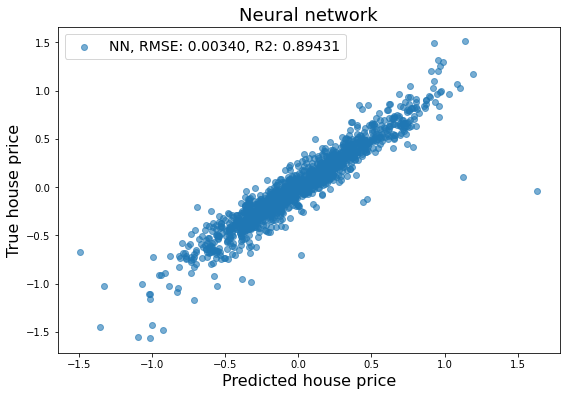

In [11]:
# calculate performance
rmse = np.linalg.norm(y - oof)/len(y)
R2 = r2_score(y, oof)

plt.figure(figsize=(9, 6))

plt.scatter(oof, y, alpha=.6, label="NN, RMSE: {:.5f}, R2: {:.5f}".format(rmse, R2))
plt.xlabel("Predicted house price", fontsize=16)
plt.ylabel("True house price", fontsize=16)

plt.legend(fontsize=14)
plt.title("Neural network", fontsize=18)
plt.show()